# 基于iTransformer的时间序列预测

In [1]:
import datetime as dt
import os
import warnings
from collections import UserDict
from tqdm import tqdm # 打印进度条
import math
from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

# 两种绘图接口
import plotly_express as px  
import plotly.graph_objects as go

%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

## 多变量多步预测

### 数据准备

In [192]:
ts_data = pd.read_csv("../data/energy.csv")
ts_data = pd.DataFrame(ts_data[["load", "temp"]].values, index=pd.to_datetime(ts_data["Unnamed: 0"].values), columns=["load", "temp"])
ts_data = ts_data.asfreq(freq='H') #转换为小时频率的数据
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [193]:
# 包含时间维度的数据集划分
def divide_dataset(df, valid_date, test_date, x_feature_list, y_feature_list):
    #归一化
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    #测试集
    train = df.copy()[df.index < valid_date][x_feature_list]
    train[x_feature_list] = x_scaler.fit_transform(train)
    train = train.values.astype('float32')

    #验证集
    valid = df.copy()[(df.index >= valid_date) & (df.index < test_date)][x_feature_list]
    valid[x_feature_list] = x_scaler.fit_transform(valid)
    valid = valid.values.astype('float32')

    #测试集
    test = df.copy()[test_date:][x_feature_list]
    test[x_feature_list] = x_scaler.fit_transform(test)
    test = test.values.astype('float32')

    #标签
    ytr = df.copy()[df.index < valid_date][y_feature_list]
    ytr[y_feature_list] = y_scaler.fit_transform(ytr)
    ytr = ytr.values.astype('float32')

    yva = df.copy()[(df.index >= valid_date) & (df.index < test_date)][y_feature_list]
    yva[y_feature_list] = y_scaler.fit_transform(yva)
    yva = yva.values.astype('float32')

    yte = df.copy()[test_date:][y_feature_list]
    yte[y_feature_list] = y_scaler.fit_transform(yte)
    yte = yte.values.astype('float32')
    return y_scaler, train, valid, test, ytr, yva, yte

In [194]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "valid_date": "2014-09-01 00:00:00",
    "test_date": "2014-11-01 00:00:00",
    "x_feature_list": ["load", "temp"],
    "y_feature_list": ["load"],
}

#函数传参
scaler, x_train, x_valid, x_test, y_train, y_valid, y_test = divide_dataset(**params1)
print("x_train shape: {0} y_train shape: {1}".format(x_train.shape, y_train.shape))
print("x_valid shape: {0} y_valid shape: {1}".format(x_valid.shape, y_valid.shape))
print("x_test shape: {0} y_test shape: {1}".format(x_test.shape, y_test.shape))

x_train shape: (23376, 2) y_train shape: (23376, 1)
x_valid shape: (1464, 2) y_valid shape: (1464, 1)
x_test shape: (1464, 2) y_test shape: (1464, 1)


In [195]:
#利用前lookback个数据，预测下delay个数据
def create_dataset(feature, target, lookback, delay, step, batch_size):
    """
    @参数设置：
    feat：输入向量
    tar：输出向量
    lookback：输入数据包含过去多少个时间步
    delay：目标应该在未来多少个时间步之后
    """
    X, y = [], []
    lookback = lookback - 1 #包含当前时间点
    #循环生成数据
    for i in range(lookback, len(feature) - delay, step):
        feat = feature[i - lookback:i + 1]
        tar = target[i + 1:i + 1 + delay]
        X.append(feat)
        y.append(tar)
    #转为张量
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    #创建dataloader
    loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
    return X, y, loader

In [196]:
# 构造参数字典
params2 = {
    "lookback": 60,
    "delay": 30,
    "step": 1, 
    "batch_size": 32,
}
X_train, y_train, train_loader = create_dataset(x_train, y_train, **params2)
X_valid, y_valid, valid_loader = create_dataset(x_valid, y_valid, **params2)
X_test, y_test, test_loader = create_dataset(x_test, y_test, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([23287, 60, 2]),y_size: torch.Size([23287, 30, 1]),loader_len: 728
X_size: torch.Size([1375, 60, 2]),y_size: torch.Size([1375, 30, 1]),loader_len: 43
X_size: torch.Size([1375, 60, 2]),y_size: torch.Size([1375, 30, 1]),loader_len: 43


### 模型训练

In [232]:
# 倒置编码
class DataEmbedding_inverted(nn.Module):
    def __init__(self, seq_len, d_model, dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(seq_len, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1))
        # x: [Batch Variate d_model]
        return self.dropout(x)

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

# iTransformer模型
class iTransformer(nn.Module):
    def __init__(self, seq_len, pred_len, output_attention, d_model, dropout, n_heads, d_ff, e_layers, activation):
        super(iTransformer, self).__init__()
        # 参数配置
        self.seq_len = seq_len # seq_len输入时间步
        self.pred_len = pred_len # pred_len输出时间步
        self.output_attention = output_attention # 是否在ecoder中输出注意力

        # Embedding
        self.enc_embedding = DataEmbedding_inverted(seq_len, d_model, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, attention_dropout=dropout,
                                      output_attention=output_attention), d_model, n_heads),
                    d_model, # 隐藏层数
                    d_ff, # ecoder中卷积层输出维度
                    dropout=dropout,
                    activation=activation # 激活函数
                ) for l in range(e_layers) # encoder layers的层数
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )

        # Decoder
        self.projection = nn.Linear(d_model, pred_len, bias=True)

    def forward(self, x_enc, x_mark_enc=None):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev

        _, _, N = x_enc.shape

        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)

        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        dec_out = self.projection(enc_out).permute(0, 2, 1)[:, :, :N]
        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))

        # output
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

In [247]:
def train(model_name, train_loader, valid_loader, train_args, model_args):
    # 参数配置
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    path = train_args['path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    
    #检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = loss
    
    # 损失函数值
    train_losses, val_losses = [], []
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 设置保存模型路径
    if not os.path.exists(path):
        os.makedirs(path)

    # 模型训练和验证
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for inputs_batch, targets_batch in train_loader:
            #将数据移至 GPU
            inputs_batch = inputs_batch.to(device)
            targets_batch = targets_batch.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(inputs_batch)
            outputs = outputs[:, :, :1] # 预测第一列的值，0代表第一列，1代表第二列
            train_loss = loss_fn(outputs, targets_batch)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for inputs_batch, targets_batch in valid_loader:
                #将数据移至 GPU
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
                val_outputs = model(inputs_batch)
                val_outputs = val_outputs[:, :, :1] # 预测第一列的值，0代表第一列，1代表第二列
                val_loss = loss_fn(val_outputs, targets_batch)
                #每个batch的loss和
                total_val_loss += val_loss.item()
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, 'type1', learning_rate, n_epochs)
        
    # 加载最佳模型
    best_model_path = path + '/' + 'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  2%|█▋                                                                                 | 1/50 [00:04<03:53,  4.77s/it]

Epoch [1/50], Training Loss: 0.0044, Validation Loss: 0.0045
Validation loss decreased (inf --> 0.004465).  Saving model ...
Updating learning rate to 0.001


  4%|███▎                                                                               | 2/50 [00:09<03:51,  4.83s/it]

Epoch [2/50], Training Loss: 0.0033, Validation Loss: 0.0045
EarlyStopping counter: 1 out of 7
Updating learning rate to 0.0005


  6%|████▉                                                                              | 3/50 [00:14<03:48,  4.86s/it]

Epoch [3/50], Training Loss: 0.0027, Validation Loss: 0.0032
Validation loss decreased (0.004465 --> 0.003248).  Saving model ...
Updating learning rate to 0.00025


  8%|██████▋                                                                            | 4/50 [00:19<03:42,  4.83s/it]

Epoch [4/50], Training Loss: 0.0024, Validation Loss: 0.0031
Validation loss decreased (0.003248 --> 0.003085).  Saving model ...
Updating learning rate to 0.000125


 10%|████████▎                                                                          | 5/50 [00:24<03:40,  4.90s/it]

Epoch [5/50], Training Loss: 0.0023, Validation Loss: 0.0030
Validation loss decreased (0.003085 --> 0.002980).  Saving model ...
Updating learning rate to 6.25e-05


 12%|█████████▉                                                                         | 6/50 [00:29<03:34,  4.87s/it]

Epoch [6/50], Training Loss: 0.0022, Validation Loss: 0.0029
Validation loss decreased (0.002980 --> 0.002922).  Saving model ...
Updating learning rate to 3.125e-05


 14%|███████████▌                                                                       | 7/50 [00:34<03:29,  4.87s/it]

Epoch [7/50], Training Loss: 0.0021, Validation Loss: 0.0029
Validation loss decreased (0.002922 --> 0.002892).  Saving model ...
Updating learning rate to 1.5625e-05


 16%|█████████████▎                                                                     | 8/50 [00:39<03:27,  4.93s/it]

Epoch [8/50], Training Loss: 0.0021, Validation Loss: 0.0029
Validation loss decreased (0.002892 --> 0.002865).  Saving model ...
Updating learning rate to 7.8125e-06


 18%|██████████████▉                                                                    | 9/50 [00:44<03:22,  4.93s/it]

Epoch [9/50], Training Loss: 0.0021, Validation Loss: 0.0029
Validation loss decreased (0.002865 --> 0.002855).  Saving model ...
Updating learning rate to 3.90625e-06


 20%|████████████████▍                                                                 | 10/50 [00:48<03:13,  4.83s/it]

Epoch [10/50], Training Loss: 0.0021, Validation Loss: 0.0029
EarlyStopping counter: 1 out of 7
Updating learning rate to 1.953125e-06


 22%|██████████████████                                                                | 11/50 [00:53<03:05,  4.76s/it]

Epoch [11/50], Training Loss: 0.0021, Validation Loss: 0.0029
EarlyStopping counter: 2 out of 7
Updating learning rate to 9.765625e-07


 24%|███████████████████▋                                                              | 12/50 [00:57<02:59,  4.72s/it]

Epoch [12/50], Training Loss: 0.0021, Validation Loss: 0.0029
EarlyStopping counter: 3 out of 7
Updating learning rate to 4.8828125e-07


 26%|█████████████████████▎                                                            | 13/50 [01:02<02:55,  4.74s/it]

Epoch [13/50], Training Loss: 0.0021, Validation Loss: 0.0029
EarlyStopping counter: 4 out of 7
Updating learning rate to 2.44140625e-07


 28%|██████████████████████▉                                                           | 14/50 [01:07<02:49,  4.70s/it]

Epoch [14/50], Training Loss: 0.0021, Validation Loss: 0.0029
EarlyStopping counter: 5 out of 7
Updating learning rate to 1.220703125e-07


 30%|████████████████████████▌                                                         | 15/50 [01:11<02:44,  4.71s/it]

Epoch [15/50], Training Loss: 0.0021, Validation Loss: 0.0029
EarlyStopping counter: 6 out of 7
Updating learning rate to 6.103515625e-08


 30%|████████████████████████▌                                                         | 15/50 [01:16<02:59,  5.12s/it]

Epoch [16/50], Training Loss: 0.0021, Validation Loss: 0.0029
EarlyStopping counter: 7 out of 7
Early stopping!


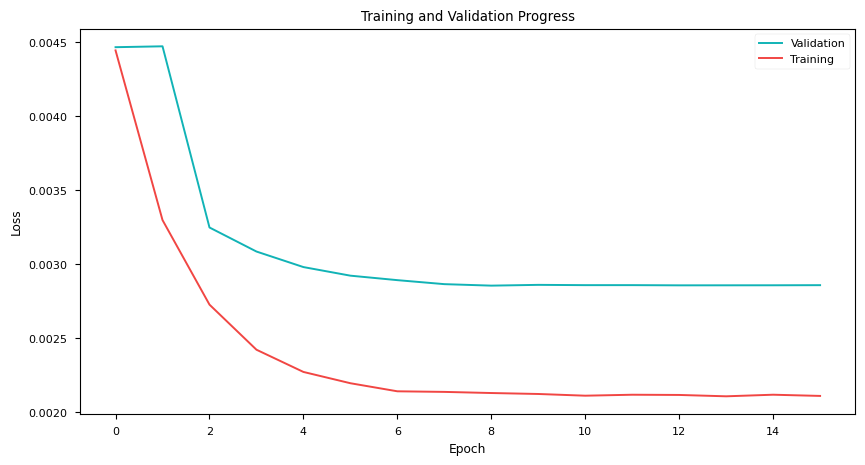

In [248]:
# 构造参数字典
params3 = {
    "model_name": iTransformer,
    "train_loader": train_loader,
    "valid_loader": valid_loader,
    "train_args": {
        "n_epochs": 50,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 7,
        "path": "../models/test",
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 2 * 30,
        'pred_len': 30,
        'output_attention': False,
        'd_model': 128,
        'n_heads': 8,
        'd_ff': 512,
        'dropout': 0.1,
        'e_layers': 1,
        'activation': "relu"
    },
}
model = train(**params3)

### 模型预测

In [249]:
def predict(model, X_train, X_valid, X_test, y_train, y_valid, y_test, y_true, y_feature_list, lookback, delay, scaler, in_tag):
    lookback = lookback - 1 # 包含当前时间点
    features = y_train.shape[-1] # 预测特征数
    
    # 字典索引生成
    col_dict = {}
    for i,j in enumerate(y_feature_list):
        col_dict[j] = i
        
    # 数据集长度
    train_size = len(X_train) + lookback + delay
    valid_size = len(X_valid) + lookback + delay
    test_size = len(X_test) + lookback + delay
    
    # 时间序列形状
    timeseries_y = y_true.values[:, col_dict[in_tag]].reshape(-1, 1)
    timeseries_x = y_true.index
    
    # 检查是否可用GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 关闭自动求导功能
    with torch.no_grad():
        '''测试集设置'''
        X_train = X_train.to(device) # 将数据应用到GPU
        y_train = y_train.to(device)
        y_pred = model(X_train)
        y_pred = y_pred[:, 0, :1].reshape(-1, features) # 0表示第一个输出
        y_pred = y_pred.cpu().detach().numpy() # 首先将张量移动到CPU，然后从计算图中分离，最后转换为NumPy数组
        y_pred = scaler.inverse_transform(y_pred) # 反归一化
        y_pred = y_pred[:,col_dict[in_tag]] # 选择要输出的列，单输出时默认为0
        train_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        train_plot_x = timeseries_x[: train_size]
        
        '''验证集设置'''
        X_valid = X_valid.to(device)
        y_valid = y_valid.to(device)
        y_pred = model(X_valid)
        y_pred = y_pred[:, 0, :1].reshape(-1, features)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        y_pred = y_pred[:,col_dict[in_tag]] # 选择要输出的列
        valid_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, ))+ [np.nan]*(delay-1)
        valid_plot_x = timeseries_x[train_size: train_size+valid_size]
        
        '''测试集设置'''
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        y_pred = y_pred[:, 0, :1].reshape(-1, features)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = scaler.inverse_transform(y_pred)
        y_pred = y_pred[:,col_dict[in_tag]] # 选择要输出的列
        test_plot_y = [np.nan]*(lookback+1) + list(y_pred.reshape(-1, )) + [np.nan]*(delay-1)
        test_plot_x = timeseries_x[train_size+valid_size: train_size+valid_size+test_size]
    return timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y

In [250]:
# 构造参数字典
params4 = {
    "model": model,
    "X_train": X_train,
    "X_valid": X_valid,
    "X_test": X_test,
    "y_train": y_train,
    "y_valid": y_valid,
    "y_test": y_test,
    "y_true": ts_data,
    "y_feature_list": ['load'],
    "lookback": 60,
    "delay": 30,
    "scaler": scaler,
    "in_tag": 'load'
}
timeseries_x, timeseries_y, train_plot_x, train_plot_y, valid_plot_x, valid_plot_y, test_plot_x, test_plot_y = predict(
    **params4)

### 结果分析

In [251]:
# 局部静态图
def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
    timeseries_x = timeseries_x[timeseries_x >= test_plot_x[0]]
    timeseries_y = timeseries_y[timeseries_y.shape[0] - len(test_plot_x):,:]
    #绘图，原始图，训练图，验证图，测试图
    fig = plt.figure(1, (10, 5))
    ax = fig.add_subplot(1,1,1)
    plt.style.use('seaborn-v0_8-paper') #绘制背景色
    plt.grid(axis = 'y',linewidth=0.35) #绘制网格
    plt.title('true-predict-curve ') #图标题
    plt.xticks(rotation = 45) #rotation文字旋转方向
    ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
    ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
    ax.legend(frameon=False) #绘制图例
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.show()

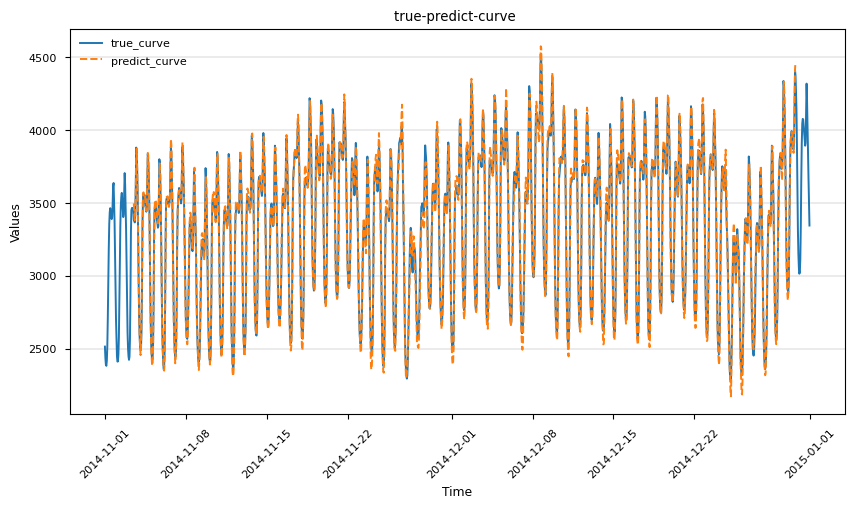

In [252]:
# 局部静态图
params5 = {
    "timeseries_x": timeseries_x,
    "timeseries_y": timeseries_y,
    "test_plot_x": test_plot_x,
    "test_plot_y": test_plot_y,
}
static_part_timeseries(**params5)

# 基于TimesNet的时间序列预测